# **BE : RN-AlgoGN**

## **Imports :**

In [98]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm
from IPython.display import HTML
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss

## **Exercice 1**

On se donne l’image Fry.bmp.  
On souhaite faire un réseau de neurones qui agissent
sur les neurones d’entrées associés à l’image Fry.bmp.  
Un neurone est un pixel de l’image qui est
à 0 ou à 1.

Pour chaque pixel i, on renvoie $e_i = 1 $ si $\sum_{j~voisin~du~pixel} a_{ji } * e_{j}$ > seuil, 0 sinon.
1) Cas 1 : les $a_{voisin} = 1$ faire varier le seuil, observer le résultat et expliquer le.
2) Cas 2 : les $a_{ji,voisin~j\ne i} = −1$, aii = α, faire varier α et la valeur du seuil, observer le résultat et expliquer le.

In [2]:
image = io.imread('Fry/Fry.bmp')

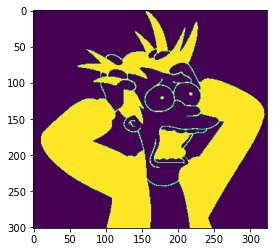

In [3]:
plt.imshow(image)

### $1^{er}$ cas : $a_{voisin} = 1$

In [4]:
def cas1(image,seuil):
    
    # on récupère les dimensions
    n,m = image.shape
    
    # les resultats sont stockés sur une nouvelles image
    results = np.zeros((n,m))
    
    #condition du cas 1
    a_voisin = 1
    
    # on parcours l'image
    for i in range(n):
        for j in range(m):
            
            calcul = 0
            
            # parcourir les voisins
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    
                    # calculer les indices des voisins
                    i2, j2 = i + di, j + dj
                    # vérifier si les indices sont dans les limites de la matrice
                    if i2 >= 0 and i2 < n and j2 >= 0 and j2 < m :
                        calcul += a_voisin * image[i2,j2]/255 #on normalise
                        
            # application de la condition
            if calcul > seuil :
                results[i,j] = 1
            else : 
                results[i,j] = 0
                
    return results

In [5]:
image2 = cas1(image,7)

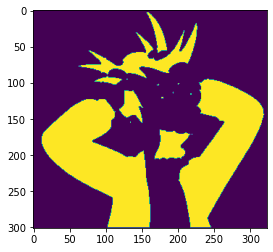

In [6]:
plt.imshow(image2)

### $2^{ème}$ cas :

In [7]:
def cas2(image,seuil=0.1,alpha=0.1):
    
     # on récupère les dimensions
    n,m = image.shape
    
    # les resultats sont stockés sur une nouvelles image
    results = np.zeros((n,m))
    
    #condition du cas 2
    a_voisin = -1
    
    # on parcours l'image
    for i in range(n):
        for j in range(m):
            
            calcul = 0
            
            # parcourir les voisins
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    
                    # calculer les indices des voisins
                    i2, j2 = i + di, j + dj
                    # vérifier si les indices sont dans les limites de la matrice
                    if i2 >= 0 and i2 < n and j2 >= 0 and j2 < m :
                        if i2 != i and j2 != j :
                            calcul += a_voisin * image[i2,j2]/255
                        else : 
                            calcul += alpha * image[i2,j2]/255
                        
            # application de la condition
            if calcul > seuil :
                results[i,j] = 1
            else : 
                results[i,j] = 0
                
    return results

In [8]:
image3 = cas2(image,1,1)

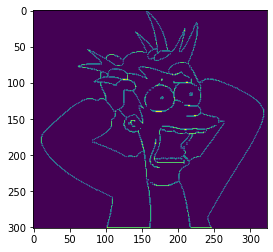

In [9]:
plt.imshow(image3)

## **Problème 2 :**

### Question 1 : Création des fonction de base du problème et du modèle

On remarque qu'une solution est [1,0,0] .
Ainsi, notre code devrais converger vers au moins une solution si il est bien fait ! 

In [10]:
def norm2(X):
    calcul = 0
    for i in X:
        calcul += i*i
    return np.sqrt(calcul)

In [11]:
def heaviside(x):
    if x < 0:
        return 0
    else:
        return 1

In [12]:
def linear(x,T=1):
    return min(1,max(0,T*x))

In [13]:
def sigmoid(x,T=1):
    return 1/(1+np.exp(-T*x))

In [14]:
# E est le vecteur d'entree
# P est le vecteur de Poids
# h est la fonction d'activation

def architecture0(E,P,h):
    return h(np.dot(E,P))

In [15]:
E_th1 = np.array([[0,0,1],
        [1,1,1],
        [1,0,1],
        [0,1,1]])
S_th1 = np.array([0,1,1,0])

In [16]:
# la norme 2 correspond à la racine de la somme des carrés des composantes
def err(Q,h,E_th,S_th):
    R = np.zeros(len(E_th))
    for i in range(len(E_th)):
        R[i] = architecture0(E_th[i],Q,h)
    return norm2(R-S_th)

In [17]:
# calcul de err pour un vecteur de poids Q et une fonction d'activation h et S
def err_vecteur(P,h,E_th,S_th):
    err_l = np.zeros(len(P))
    for i in range(len(P)):
        err_l[i]=err(P[i],h,E_th,S_th)
    return err_l

### Question 2 : initialisation d'une population et affichage des erreurs

In [18]:
def generation_P(taille_pop):
    return np.random.uniform(-20,20,(taille_pop,3))

In [19]:
err_vecteur(generation_P(20),heaviside,E_th1,S_th1)

array([1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.73205081, 1.41421356, 0.        , 1.41421356, 1.41421356,
       1.41421356, 1.73205081, 1.41421356, 1.73205081, 1.41421356,
       1.73205081, 1.73205081, 1.41421356, 1.41421356, 1.41421356])

### Question 3 : création d'un algo génétique d'amélioration de poids

Ici, on va suivre 3 étapes pour réaliser l'aglo génétique :
- sélection des meilleurs fourmis
- Croisement 
- mutation 

In [20]:
# crée une fonction trie le vecteur Poids selon la fonction d'erreur err
def trier(P,h,E_th,S_th):
    return P[np.argsort(err_vecteur(P,h,E_th,S_th))]

In [21]:
# comme P est trié, on sait que le meilleur indice est 0 (on cherche à minimiser l'erreur)
def croisement(P,n_croisement):
    n = len(P)
    for i in range(n_croisement):
        P[n-1-i] = (P[0]+P[n-1-i])/2
    return P

In [55]:
def mutation(P,n_mutation,n_croisement,alpha):
    n = len(P)
    for i in range(n_mutation):
        P[n-1-i-n_croisement] = P[0]+(2*np.random.rand(3)-1)*alpha
    return P

In [23]:
# P est la population de poids
# h est la fonction d'activation
# n_croisement est le nombre de croisement à effectuer
# n_mutation est le nombre de mutation à effectuer
# alpha est le facteur de mutation
# n_gen est le nombre de génération à effectuer

def algo_genetique(P,h,n_croisement,n_mutation,alpha,n_gen,E_th,S_th):
    for i in range(n_gen):
        P = trier(P,h,E_th,S_th)
        P = croisement(P,n_croisement)
        P = mutation(P,n_mutation,n_croisement,alpha)
    return P

In [24]:
test = generation_P(20)

In [25]:
print(test)

[[  8.03484745  -9.83534206  -0.072491  ]
 [-10.16315752   6.87812567 -16.461161  ]
 [ -5.21556288  -2.74735682 -18.34824989]
 [ 19.84274824   1.45857628  16.61068133]
 [ -1.3107941  -14.40520457   5.14030758]
 [ -4.66845346  -2.71997031  -4.99045692]
 [ -2.38431007   4.72224735  -9.85025355]
 [  0.73052524  12.53895264  -2.72546171]
 [-17.57984105   3.6549057   -4.75001926]
 [  1.29702189   7.38128564  -9.76454601]
 [-11.36569877 -11.83196802 -17.55023746]
 [-15.73981233 -11.16170571  -6.90131926]
 [-15.43080538 -14.84136683  15.77352901]
 [ 16.55306579  18.55092985  11.4817876 ]
 [  7.63352338  -4.80895905 -14.07731079]
 [ 10.59117132   6.88309971   1.71263102]
 [ 10.09079895 -12.33050077  -0.16030353]
 [ 11.64017592  -1.62838471  12.52220493]
 [  3.66454736 -13.3182179  -13.51390705]
 [-16.69457809  -7.50806278   6.52923758]]


In [26]:
# avec heaviside
P1 = algo_genetique(test,heaviside,5,5,0.1,100,E_th1,S_th1)
print(P1)
print(err_vecteur(P1,heaviside,E_th1,S_th1))

[[ 8.03484745e+00 -9.83534206e+00 -7.24910043e-02]
 [ 8.04880149e+00 -9.82547140e+00 -5.33079723e-02]
 [ 8.05153909e+00 -9.80871272e+00 -6.87660855e-02]
 [ 8.04982131e+00 -9.82089228e+00 -5.96661762e-02]
 [ 8.04697952e+00 -9.79531042e+00 -5.45950415e-02]
 [ 8.06421853e+00 -9.81644770e+00 -2.31669579e-02]
 [ 8.09273605e+00 -9.75080669e+00 -2.13201201e-02]
 [ 8.05968109e+00 -9.80712125e+00 -4.57789184e-02]
 [ 8.08164297e+00 -9.79963401e+00 -2.61261467e-02]
 [ 8.05912945e+00 -9.82222191e+00 -5.18424580e-02]
 [ 8.11103162e+00 -9.75554573e+00  2.02275798e-03]
 [ 8.04534901e+00 -9.79044557e+00 -2.06798904e-02]
 [ 8.05239322e+00 -9.76680517e+00  2.73402425e-02]
 [ 8.07437377e+00 -9.77352217e+00  7.11627539e-03]
 [ 8.09903559e+00 -9.76128571e+00 -5.66927381e-02]
 [ 8.04130702e+00 -9.82754858e+00 -6.21632130e-02]
 [ 8.04199150e+00 -9.82354489e+00 -6.27256395e-02]
 [ 8.05214626e+00 -9.79849600e+00 -6.02447427e-02]
 [ 8.04737484e+00 -9.82091329e+00 -5.15854499e-02]
 [ 8.05165530e+00 -9.83059087e+

In [27]:
# avec linear
P2 = algo_genetique(test,linear,5,5,0.1,100,E_th1,S_th1)
print(P2)
print(err_vecteur(P2,linear,E_th1,S_th1))

[[ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.72889762 -1.44289989 -1.38992627]
 [ 6.81748731 -1.46528127 -1.43973064]
 [ 6.78507579 -1.41060977 -1.3946598 ]
 [ 6.78923854 -1.47315284 -1.38290658]
 [ 6.76076583 -1.47477624 -1.39505143]
 [ 8.04998918 -1.45694035 -0.29067655]
 [ 6.75321314 -1.38304293 -1.37345975]
 [ 6.75327711 -1.38643718 -1.41354008]
 [ 6.72708261 -1.43048968 -1.39932792]
 [ 6.79966649 -1.43998688 -1.41550703]
 [ 6.74887931 -1.46513698 -1.38133282]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]
 [ 6.71871828 -1.47674293 -1.45165399]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
# avec sigmoid
P3 = algo_genetique(test,sigmoid,5,5,0.1,100,E_th1,S_th1)
print(P3)
print(err_vecteur(P3,sigmoid,E_th1,S_th1))

[[ 6.4047037  -1.35773532 -1.60352984]
 [ 6.36704585 -1.35878749 -1.60467923]
 [ 6.27194828 -1.44631461 -1.60591052]
 [ 6.4536032  -1.2986053  -1.60452367]
 [ 6.25246572 -1.47066685 -1.60648734]
 [ 6.44063461 -1.33774332 -1.60190903]
 [ 6.44851767 -1.34058215 -1.60125413]
 [ 6.48138648 -1.2864534  -1.60313019]
 [ 6.40768985 -1.29700901 -1.60446382]
 [ 6.38825742 -1.31047974 -1.60414866]
 [ 6.46758323 -1.28140378 -1.54174072]
 [ 6.45696637 -1.2621345  -1.56548921]
 [ 6.48182281 -1.25889148 -1.5612217 ]
 [ 6.46643967 -1.27647111 -1.58660571]
 [ 6.45758696 -1.28359328 -1.56655781]
 [ 6.42208669 -1.33414492 -1.58549219]
 [ 6.42804836 -1.33814258 -1.58345148]
 [ 6.42470929 -1.35679855 -1.57036809]
 [ 6.45442554 -1.30922972 -1.5604061 ]
 [ 6.4182347  -1.35453165 -1.55374318]]
[0.17747996 0.17753212 0.17759854 0.1776216  0.17763667 0.17768067
 0.17770813 0.1778236  0.17786633 0.17788278 0.1868737  0.18363977
 0.18421659 0.18036005 0.18322111 0.18012253 0.18034656 0.18206295
 0.18384203 0.1845

### Exercice 2bis : Même chose que l'exercice 2 mais avec une tableau théorique différente

In [29]:
E_th2 = np.array([
        [0,0,1],
        [1,1,1],
        [1,0,1],
        [0,1,1]])
S_th2 = np.array([0,0,1,1])

In [30]:
test2 = generation_P(20)
print(test2)

[[ -3.02394826   0.92812098 -16.05445275]
 [-19.38596036   0.22695957  14.10693747]
 [  7.24826521 -15.33762882  -8.06999872]
 [  4.88317516 -18.48887215   2.82412563]
 [-17.55658391 -11.0232652  -17.63580759]
 [ -5.70927309 -16.03953928  15.93306868]
 [ 16.51208821   8.18282951  -6.55513322]
 [ -7.18629555 -14.70673511   5.84980473]
 [-12.00624311  -6.41271975  16.75728173]
 [ 16.38748589  -1.95200506  -2.45360582]
 [  8.28909464   0.47520978  12.68649285]
 [-16.25705532 -15.95664311   0.14749741]
 [  6.02491881  19.65367232   5.31078287]
 [-16.63180405   5.04947791  -7.76607578]
 [ -8.60087833   9.22438717  -8.6300007 ]
 [-12.05392986   1.71034948  12.98250512]
 [ -9.23989664  19.32008801 -13.82909886]
 [  3.0339521    2.71046988 -13.09961558]
 [ 15.75222948  12.18995157  15.40928673]
 [ -8.41110712   5.77458058   2.52236983]]


In [31]:
# avec heaviside
P12 = algo_genetique(test2,heaviside,5,5,0.1,100,E_th2,S_th2)
print(P12)
print(err_vecteur(P12,heaviside,E_th2,S_th2))

[[ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.16460364  19.34499505 -13.82816296]
 [ -9.22877166  19.36101434 -13.75688968]
 [ -9.21048384  19.35179242 -13.76719148]
 [ -9.1537291   19.41056344 -13.79840307]
 [ -9.18915434  19.35571481 -13.82740961]
 [ -9.15288112  19.34602819 -13.74077563]
 [ -9.15378945  19.38777143 -13.7493351 ]
 [ -9.23594112  19.33766198 -13.77164075]
 [ -9.16852177  19.36637171 -13.73490494]
 [ -9.1995944   19.35478596 -13.78048307]
 [ -9.19709481  19.34883363 -13.77436832]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
# avec linear
P22 = algo_genetique(test2,linear,5,5,0.1,100,E_th2,S_th2)
print(P22)
print(err_vecteur(P22,linear,E_th2,S_th2))

[[ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.21181048  19.40657201 -13.76110147]
 [ -9.23555265  19.40399165 -13.76885467]
 [ -9.19749506  19.34330267 -13.81077713]
 [ -9.15737708  19.3561038  -13.8209299 ]
 [ -9.18503486  19.37489962 -13.77985127]
 [ -9.15866552  19.334438   -13.80425042]
 [ -9.2026144   19.33568717 -13.74684212]
 [ -9.20390545  19.40784163 -13.79617505]
 [ -9.20491756  19.41417662 -13.79694207]
 [ -9.17728069  19.414527   -13.77766896]
 [ -9.23192323  19.33168529 -13.76285614]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]
 [ -9.23989664  19.32008801 -13.82909886]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [33]:
# avec sigmoid
P32 = algo_genetique(test2,sigmoid,5,5,0.1,100,E_th2,S_th2)
print(P32)
print(err_vecteur(P32,sigmoid,E_th2,S_th2))

[[ -9.5264539   17.81045805 -13.03489449]
 [ -9.52582291  17.79180345 -13.01511347]
 [ -9.53044987  17.78231546 -13.07103039]
 [ -9.53027675  17.82546413 -13.00669218]
 [ -9.52274116  17.78372154 -13.03102268]
 [ -9.52326167  17.81358608 -13.02579586]
 [ -9.52771431  17.87833852 -13.0517394 ]
 [ -9.51903183  17.80558673 -13.04798819]
 [ -9.52158074  17.82746881 -13.02271417]
 [ -9.52123611  17.83003904 -13.02233048]
 [ -9.44444047  17.84648828 -12.99521416]
 [ -9.47767414  17.82924163 -12.99388732]
 [ -9.5147912   17.89828361 -13.00099299]
 [ -9.50002956  17.81771328 -13.02299759]
 [ -9.50220783  17.85339876 -12.98440892]
 [ -9.50961806  17.82170346 -13.02407155]
 [ -9.50213324  17.82809408 -13.03105894]
 [ -9.50357343  17.83138701 -12.99447508]
 [ -9.50141475  17.85477117 -13.01995124]
 [ -9.4986908   17.85848131 -12.98792901]]
[1.00007169 1.00007174 1.00007179 1.0000718  1.00007194 1.00007199
 1.00007213 1.0000722  1.00007229 1.00007235 1.00008028 1.00007659
 1.00007529 1.00007386 1.

On observe que nous ne convergeons pas vers une solution, je suppose quec c'est un problème non linéaire qui va demander l'utilisation de couches supplémentaires.

## **Problème 2 bis : Réseau de Neurones Multi-Couches**

Ajout d'une couche intermédiaire de 4 neurones  
On transforme P en liste de listes de poids (chaque liste correspond à une couche)



In [34]:
# Nouvelle initialisation :
def generation_P_multicouche(taille_pop,taille_entree,liste_nb_neurones_par_couche):
    P = []
    for i in range(taille_pop):
        P.append([])
        for j in range(len(liste_nb_neurones_par_couche)) :
            if j == 0 :
                P[i].append(np.random.uniform(-20,20,(liste_nb_neurones_par_couche[j],taille_entree)))
            else :
                P[i].append(np.random.uniform(-20,20,(liste_nb_neurones_par_couche[j],liste_nb_neurones_par_couche[j-1])))
    return P

In [35]:
test = generation_P_multicouche(2,3,[2,3])
print(test[0])

[array([[-10.20683329, -14.6817326 ,  -4.79421855],
       [ -3.87919402,   5.0687972 ,  16.18453172]]), array([[  9.11728617, -16.84833348],
       [ -2.77619151,  16.29388958],
       [  6.67324246,  15.27461484]])]


In [36]:
# Calul de la sortie avec la nouvelle architecture pour un réseau ! 
def sortie_reseau(E,P,h):
    R = E
    for couche in range(len(P)):
        R_aux = []
        for neurone in range(len(P[couche])):
            R_aux.append(h(np.dot(R,P[couche][neurone])))
        R = np.array(R_aux)
    return R

In [37]:
sortie_reseau(E_th2[0],test[0],heaviside)

array([0, 1, 1])

In [38]:
# on remet la fonction d'err pour un réseau avec la nouvelle architecture
def err_reseau(reseau,h,E_th,S_th):
    R = np.zeros(len(E_th))
    for i in range(len(E_th)):
        R[i] = sortie_reseau(E_th[i],reseau,h)
    return norm2(R-S_th)

In [39]:
# idem pour un vecteur de réseau
def err_vecteur_reseaux(vecteur_reseaux,h,E_th,S_th):
    err_l = np.zeros(len(vecteur_reseaux))
    for i in range(len(vecteur_reseaux)):
        reseau = vecteur_reseaux[i]
        err_l[i]=err_reseau(reseau,h,E_th,S_th)
    return err_l

In [40]:
# testons le code :
test = generation_P_multicouche(2,3,[2,1])
print(test)
print(err_vecteur_reseaux(test,heaviside,E_th2,S_th2))

[[array([[ -0.73913599,   7.16448865, -19.4402254 ],
       [ -1.17032103,  11.81988573,  15.10100127]]), array([[-16.82998919, -18.85860642]])], [array([[  9.00705087,  16.96558899,   5.61834133],
       [  5.65674158,  -5.85642349, -11.39272207]]), array([[0.6860179 , 8.96758234]])]]
[1.41421356 1.41421356]


### **Amélioration Génétique :**

On souhaite maintenant améliorer nos réseaux de Neurones à l'aide d'un algo génétique afin de trouver une solution à notre problème.

In [41]:
# on adapte la fonction trier :
def trier_reseau(P,h,E_th,S_th):
    err_l = err_vecteur_reseaux(P,h,E_th,S_th)
    P = [x for _,x in sorted(list(zip(err_l,P)),key = lambda x: x[0])]
    return P


In [42]:
# on adapte la fonction croisement :
def croisement_reseau(P,n_croisement):
    n = len(P)
    for i in range(n_croisement):
        P[n-1-i] = np.add(P[0],P[n-1-i])/2
    return P

In [43]:
# on adapte la fonction mutation :
def mutation_reseau(P,n_mutation,n_croisement,alpha):
    n = len(P)
    for i in range(n_mutation):
        P[n-1-i-n_croisement] = np.add(P[0],alpha*np.random.rand())
    return P

In [56]:
# version corrigé par le prof : on change tous les poids d'un neurone sur n_mutation réseaux
def mutation_reseau_2(P,n_mutation,n_croisement,alpha):
    n = len(P)
    nbdecouche = len(P[0])
    for i in range(n_mutation):
        choix_couche=np.random.randint(nbdecouche) # on choisis une couche
        nbdepoidsdelacouchechoix_couche=P[0][choix_couche].shape[0] 
        choix_element=np.random.randint(nbdepoidsdelacouchechoix_couche) # on choisis un neurone
        nb_lien_neurone = len(P[0][choix_couche][choix_element])
        for lien in range(nb_lien_neurone) :
            P[n-1-i-n_croisement][choix_couche][choix_element][lien]=max(min(P[0][choix_couche][choix_element][lien]+alpha*(2*np.random.rand()-1),20),-20)
    return P

In [57]:
#on test
test = generation_P_multicouche(2,3,[2,1])
print("trier",trier_reseau(test,heaviside,E_th2,S_th2))
print("croisement",croisement_reseau(test,0))
print("mutation",mutation_reseau_2(test,1,0,0.1))

trier [[array([[-19.58536064,   7.60361502,  -0.62448573],
       [ -6.31125283,   4.26634327, -15.62593697]]), array([[  0.78215824, -10.26963428]])], [array([[ 13.93838536, -13.42133597, -15.86371501],
       [ 11.33052702,  -1.66503171,  14.90893634]]), array([[ 6.04500882, -0.04252483]])]]
croisement [[array([[-19.58536064,   7.60361502,  -0.62448573],
       [ -6.31125283,   4.26634327, -15.62593697]]), array([[  0.78215824, -10.26963428]])], [array([[ 13.93838536, -13.42133597, -15.86371501],
       [ 11.33052702,  -1.66503171,  14.90893634]]), array([[ 6.04500882, -0.04252483]])]]
mutation [[array([[-19.58536064,   7.60361502,  -0.62448573],
       [ -6.31125283,   4.26634327, -15.62593697]]), array([[  0.78215824, -10.26963428]])], [array([[ 13.93838536, -13.42133597, -15.86371501],
       [ 11.33052702,  -1.66503171,  14.90893634]]), array([[  0.70380483, -10.18873852]])]]


In [58]:
# on réalise l'algo_genetique_reseau
def algo_genetique_reseau(P,h,n_croisement,n_mutation,alpha,n_iter,E_th,S_th):
    for _ in range(n_iter):
        P = trier_reseau(P,h,E_th,S_th)
        P = croisement_reseau(P,n_croisement)
        P = mutation_reseau_2(P,n_mutation,n_croisement,alpha)
    return P


In [59]:
# on test l'ensemble
test = generation_P_multicouche(20,3,[4,1])
print("err_vecteur_reseaux :", err_vecteur_reseaux(test,heaviside,E_th2,S_th2))
P_reseau_gene = algo_genetique_reseau(test,heaviside,5,2,1,200,E_th2,S_th2)
print("err_vecteur_reseaux :", err_vecteur_reseaux(P_reseau_gene,heaviside,E_th2,S_th2))



err_vecteur_reseaux : [1.41421356 1.41421356 1.73205081 1.41421356 1.41421356 1.
 1.41421356 1.         1.41421356 1.41421356 1.         1.73205081
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.
 1.41421356 1.41421356]


C:\Users\valen\AppData\Local\Temp/ipykernel_9428/3799146451.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P[n-1-i] = np.add(P[0],P[n-1-i])/2


err_vecteur_reseaux : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Le code à l'air de fonctionner un peu aléatoirement, on va essayer d'ajuster les paramètres afin d'avoir une formule qui marche :

In [60]:
# on réalise l'algo_genetique_reseau
def algo_genetique_reseau_etude(P,h,n_croisement,n_mutation,alpha,n_iter,E_th,S_th):
    Liste_err = [min(err_vecteur_reseaux(P,h,E_th,S_th))]
    for _ in range(n_iter):
        P = trier_reseau(P,h,E_th,S_th)
        P = croisement_reseau(P,n_croisement)
        P = mutation_reseau_2(P,n_mutation,n_croisement,alpha)
        Liste_err.append(min(err_vecteur_reseaux(P,h,E_th,S_th)))
    return P,Liste_err

In [69]:
# on test l'ensemble
test = generation_P_multicouche(20,3,[4,1])
print("err_vecteur_reseaux :", err_vecteur_reseaux(test,sigmoid,E_th2,S_th2))
P_reseau_gene,List_err = algo_genetique_reseau_etude(test,sigmoid,8,8,1,200,E_th2,S_th2)
print("err_vecteur_reseaux :", err_vecteur_reseaux(P_reseau_gene,sigmoid,E_th2,S_th2))

err_vecteur_reseaux : [1.43300246 0.99999641 1.41421356 1.41421356 1.41421356 1.41330591
 1.41421355 1.41421142 1.41406685 1.25570545 1.27464481 1.41420911
 1.29972618 1.4142134  1.18658996 1.56621185 1.41421356 1.01407258
 1.42913964 1.41421352]


C:\Users\valen\AppData\Local\Temp/ipykernel_9428/3799146451.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P[n-1-i] = np.add(P[0],P[n-1-i])/2


err_vecteur_reseaux : [8.98014739e-05 8.98498659e-05 9.10149435e-05 9.16634092e-05
 1.16845153e-04 1.18068620e-04 1.07569912e-04 9.38868236e-05
 9.36907803e-05 9.60769016e-05 9.46080402e-05 1.05803795e-04
 9.19955645e-05 9.54832338e-05 9.42429871e-05 9.63499088e-05
 9.79893887e-05 9.71228445e-05 1.14907750e-04 9.72465596e-05]


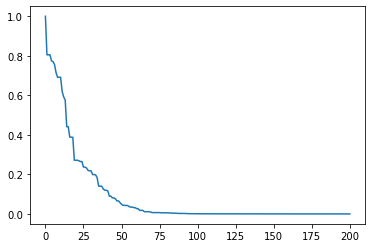

In [71]:
plt.plot(List_err)

### **Amélioration Back propagation :**

Ici, on souhaite améliorer notre réseau de neurone à l'aide d'une descente de gradient (cf cours de Machine Learnia sur YTB)

L'idée est de regarder les variations (pentes) des différentes poids autour d'eux et d'ajouter un léger décalage

Il faudra donc regarder le retour de chaque neurone ! 

Ici, on utilise la même structure que dans le reste de l'exo, mais une structure de stockage intéressante pour les paramètres (ici les poids), les activations, les gradients ... est la strucure de **dictionnaire**.  
Pour voir le code en version dictionnaire, aller sur le code de la dernière vidéo de la série Réseau de Neurones de Machine Learnia

**A REFAIRE EN VERSION DICTIONNAIRE** : pour comprendre toutes les étapes

In [110]:
# Initialisation (version dictionnaire de tableaux numpy)
def initialisation(dimensions):
    
    parametres = {}
    C = len(dimensions)

    np.random.seed(1) # pour comparer les réseaux générés

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [111]:
# pour cette descente de gradient, les calculs ont été fait avec simoide (sinon il faut tt recalculer théoriquement)
def forward_propagation(X, parametres):
  
  activations = {'A0': X}

  C = len(parametres) // 2 # pour chaque couche on a la liste des poids pour chaque neurones et leurs constantes respectives !

  for c in range(1, C + 1): # on a commencé la nomination à 1 !

    Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
    activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

  return activations

In [112]:
def back_propagation(y, parametres, activations):

  m = y.shape[1]
  C = len(parametres) // 2

  dZ = activations['A' + str(C)] - y  #on regarde les écarts !
  gradients = {}

  for c in reversed(range(1, C + 1)): # on remonte les couches
    gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T) # voir calcul théorique
    gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True) # idem
    if c > 1:
      dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)]) #maj dZ (voir calcul théorique)

  return gradients

In [113]:
def update(gradients, parametres, learning_rate): # on met à jour les réseaux neuroneaux

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [133]:
def predict(X, parametres,seuil=0.5): # fonction de prédiction
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  Af = activations['A' + str(C)]
  return Af

In [145]:
# création du réseau + affiche de son apprentissage
def deep_neural_network(X, y, hidden_layers = (16, 16, 16), learning_rate = 0.001, n_iter = 3000):
    
    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0]) # on ajoute les poids entre l'entrée et la première couche cachée
    dimensions.append(y.shape[0]) # idem pour la sortie
    print(dimensions)
    np.random.seed(1)
    parametres = initialisation(dimensions)
    
    C = len(parametres) // 2

    # gradient descent
    for i in tqdm(range(n_iter)):
        #print("paramètres: " , parametres)
        activations = forward_propagation(X, parametres)
        #print("activations" ,activations)
        gradients = back_propagation(y, parametres, activations)
        #print("gradients :",gradients)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]

    return parametres

In [146]:
# on test (bien mettre une sortie en (n,m) et non en (n,))
reseau = deep_neural_network(E_th2, S_th2.reshape((S_th2.shape[0], 1)).T, hidden_layers = (4,), learning_rate = 0.1, n_iter = 1000)

[4, 4, 1]


  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (1,3) (1,4) 

In [139]:
# test du réseau
print("réseau :",reseau)
print("prédiction :", predict(E_th2, reseau))
print("réel :", S_th2)


réseau : {'W1': array([[ 1.67747338e+00, -3.89738661e-01, -3.43830806e-01,
        -9.82163801e-01],
       [ 8.44304118e-01, -2.39961248e+00,  1.64277488e+00,
        -7.78347310e-01],
       [ 2.90208923e-01, -3.59303818e-01,  1.34229713e+00,
        -2.07909351e+00],
       [-1.65911275e-02,  8.60117585e-01,  1.58183576e+00,
         2.04043431e-03]]), 'b1': array([[ 0.04958954],
       [-0.9759322 ],
       [-0.0677197 ],
       [ 1.82698715]]), 'W2': array([[-1.74536437,  0.80792634, -0.13426564, -1.9214194 ],
       [ 0.2432746 , -0.98455068, -0.93456216, -3.31302129],
       [ 0.32942488,  0.82537113,  0.19067217,  1.851866  ],
       [ 0.01286197, -0.48637014,  0.3655703 ,  2.50764243]]), 'b2': array([[-4.15688551],
       [-2.97998161],
       [ 4.42428427],
       [ 3.96909151]])}
prédiction : [[1.34283249e-03 1.79493390e-03 1.06871588e-03]
 [9.28559562e-04 2.20073328e-03 1.41966747e-03]
 [9.98669969e-01 9.98082484e-01 9.98645717e-01]
 [9.98687371e-01 9.98238748e-01 9.9846622

## **Exercice 3 : Détections chiffres**

In [75]:
# import des données du fichier train-only-input-48x218.data
data = np.loadtxt("data/train-only-input-48x218.data",delimiter = " ")
etiquette = np.loadtxt("data/train-only-output-1x218.data",delimiter = " ")

In [76]:
data.shape

(218, 48)

In [ ]:
etiquette[200]

9.0

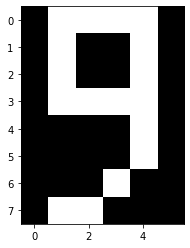

In [ ]:
# Visualisation des données :
plt.imshow(data[200].reshape(8,6),cmap = "gray")

In [ ]:
# transformation en dataframe
df = pd.DataFrame(data)
df["etiquette"] = etiquette

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,etiquette
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0
214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,9.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,9.0
216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,9.0


In [ ]:
# stat sur les etiquettes 
df["etiquette"].value_counts()

3.0    30
6.0    28
0.0    24
1.0    23
9.0    21
2.0    20
7.0    19
4.0    18
5.0    18
8.0    17
Name: etiquette, dtype: int64

On va utiliser la méthode génétique vue dans l'exo 2bis pour résoudre ce problème 

In [72]:
# Nouvelle initialisation :
def generation_P_multicouche(taille_pop,taille_entree,liste_nb_neurones_par_couche):
    P = []
    for i in range(taille_pop):
        P.append([])
        for j in range(len(liste_nb_neurones_par_couche)) :
            if j == 0 :
                P[i].append(np.random.uniform(-20,20,(liste_nb_neurones_par_couche[j],taille_entree)))
            else :
                P[i].append(np.random.uniform(-20,20,(liste_nb_neurones_par_couche[j],liste_nb_neurones_par_couche[j-1])))
    return P

In [73]:
# Calul de la sortie pour une entrée
def sortie_reseau(E,P,h):
    R = E
    for couche in range(len(P)):
        R_aux = []
        for neurone in range(len(P[couche])):
            R_aux.append(h(np.dot(R,P[couche][neurone])))
        R = np.array(R_aux)
    return R

In [84]:
# on calcul l'erreur pour une liste d'entrée (ici la sortie doit être multipliée par 10 !!! (cas 1))
def err_reseau(reseau,h,X,y):
    R = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        R[i] = sortie_reseau(X[i],reseau,h)
    return norm2(R*10-y) / y.shape[0] #pour avoir l'erreur moyenne

In [78]:
# on répète l'opération pour un vecteur de réseaux
def err_vecteur_reseaux(vecteur_reseaux,h,X,y):
    err_l = np.zeros(len(vecteur_reseaux))
    for i in range(len(vecteur_reseaux)):
        reseau = vecteur_reseaux[i]
        err_l[i]=err_reseau(reseau,h,X,y)
    return err_l

In [79]:
# on trie le réseau
def trier_reseau(P,h,X,y):
    err_l = err_vecteur_reseaux(P,h,X,y)
    P = [x for _,x in sorted(list(zip(err_l,P)),key = lambda x: x[0])]
    return P

In [80]:
# on fait le croisement :
def croisement_reseau(P,n_croisement):
    n = len(P)
    for i in range(n_croisement):
        P[n-1-i] = np.add(P[0],P[n-1-i])/2
    return P

In [81]:
# on fait la mutation sur tt les liaisons d'un neurone
def mutation_reseau_2(P,n_mutation,n_croisement,alpha):
    n = len(P)
    nbdecouche = len(P[0])
    for i in range(n_mutation):
        choix_couche=np.random.randint(nbdecouche) # on choisis une couche
        nbdepoidsdelacouchechoix_couche=P[0][choix_couche].shape[0] 
        choix_element=np.random.randint(nbdepoidsdelacouchechoix_couche) # on choisis un neurone
        nb_lien_neurone = len(P[0][choix_couche][choix_element])
        for lien in range(nb_lien_neurone) :
            P[n-1-i-n_croisement][choix_couche][choix_element][lien]=max(min(P[0][choix_couche][choix_element][lien]+alpha*(2*np.random.rand()-1),20),-20)
    return P

In [86]:
# on réalise l'algo_genetique_reseau (avec courbe d'apprentissage)
def algo_genetique_reseau_etude(P,h,n_croisement,n_mutation,alpha,n_iter,E_th,S_th):
    Liste_err = [min(err_vecteur_reseaux(P,h,E_th,S_th))]
    for _ in tqdm(range(n_iter)):
        P = trier_reseau(P,h,E_th,S_th)
        P = croisement_reseau(P,n_croisement)
        P = mutation_reseau_2(P,n_mutation,n_croisement,alpha)
        Liste_err.append(min(err_vecteur_reseaux(P,h,E_th,S_th)))
    return P,Liste_err

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\valen\AppData\Local\Temp/ipykernel_9428/940901847.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P[n-1-i] = np.add(P[0],P[n-1-i])/2
100%|██████████| 400/400 [19:29<00:00,  2.92s/it]


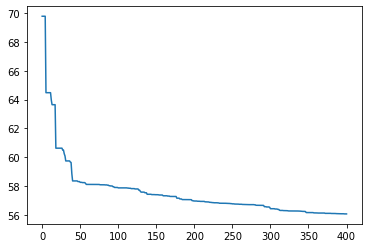

In [96]:
# on test
P = generation_P_multicouche(10,48,[128,8,1])
P,Liste_err = algo_genetique_reseau_etude(P,sigmoid,3,5,0.1,400,data,etiquette)
plt.plot(Liste_err)

In [90]:
# pour la version avec sortie à 4bit, il faut juste remplacé l'évaluation + la liste des neurones
def err_reseau_4bit(reseau,h,X,y):
    R = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        aux = sortie_reseau(X[i],reseau,h)
        R[i] = int("".join([str(int(x)) for x in aux]),2) #passage base 2 à 10
    return norm2(R-y) 

In [91]:
# on répète l'opération pour un vecteur de réseaux
def err_vecteur_reseaux_4bit(vecteur_reseaux,h,X,y):
    err_l = np.zeros(len(vecteur_reseaux))
    for i in range(len(vecteur_reseaux)):
        reseau = vecteur_reseaux[i]
        err_l[i]=err_reseau_4bit(reseau,h,X,y)
    return err_l

In [92]:
# on trie le réseau
def trier_reseau_4bit(P,h,X,y):
    err_l = err_vecteur_reseaux_4bit(P,h,X,y)
    P = [x for _,x in sorted(list(zip(err_l,P)),key = lambda x: x[0])]
    return P

In [93]:
# croissement et mutation sont identiques !
def algo_genetique_reseau_4bit_etude(P,h,n_croisement,n_mutation,alpha,n_iter,E_th,S_th):
    Liste_err = [min(err_vecteur_reseaux_4bit(P,h,E_th,S_th))]
    for _ in tqdm(range(n_iter)):
        P = trier_reseau_4bit(P,h,E_th,S_th)
        P = croisement_reseau(P,n_croisement)
        P = mutation_reseau_2(P,n_mutation,n_croisement,alpha)
        Liste_err.append(min(err_vecteur_reseaux_4bit(P,h,E_th,S_th)))
    return P,Liste_err

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\valen\AppData\Local\Temp/ipykernel_9428/940901847.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P[n-1-i] = np.add(P[0],P[n-1-i])/2
100%|██████████| 400/400 [10:15<00:00,  1.54s/it]


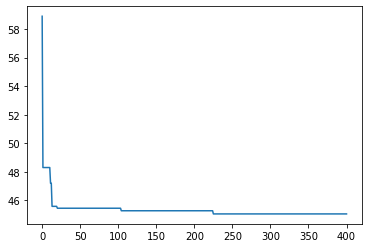

In [95]:
# on test
P_4bit = generation_P_multicouche(10,48,[128,8,4])
P_4bit,Liste_err = algo_genetique_reseau_4bit_etude(P_4bit,heaviside,3,5,0.1,400,data,etiquette)
plt.plot(Liste_err)

**Conclusion** : les deux méthodes fonctionnes, cependant en utilisant une écriture 4bit avec *Heaviside* on obtient des résultats + rapidement car les calculs sont plus simples. De plus, ils ont l'air de meilleur qualité (à confirmer en laissant plus de convergence)

In [102]:
# mesure de l'accuracy du réseau 4bit:
def accuracy_reseau_4bit(reseau,h,X,y):
    R = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        aux = sortie_reseau(X[i],reseau,h)
        R[i] = int("".join([str(int(x)) for x in aux]),2) #passage base 2 à 10
    return np.sum(R==y)/y.shape[0]

In [106]:
# mesure de l'accuracy
def accuracy_reseau(reseau,h,X,y):
    R = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        R[i] = sortie_reseau(X[i],reseau,h)
    # on arrondie car on veut des entiers
    R = np.round(R)
    return np.sum(R==y)/y.shape[0]

In [107]:
# on test (on prends le meilleur réseau du vecteur)
accuracy_reseau(P[0],sigmoid,data,etiquette)

0.0963302752293578

In [108]:
# on test
accuracy_reseau_4bit(P_4bit[0],heaviside,data,etiquette)


NameError: name 'P_4bit' is not defined

## **Exercice 4 : Réseau de Neurone itératif sur une image d'Alien**

In [ ]:
image2 = io.imread('Alien.jpg')

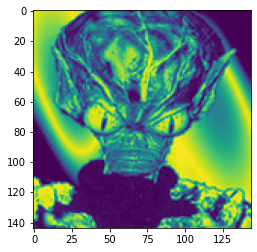

In [ ]:
plt.imshow(image2)

In [ ]:
image2.shape

(144, 144)

In [ ]:
# définition de la matrice de poids :
P = [[-1.6,0.4,-1.5],
     [0.1,6.7,0.1],
     [-1.5,0.4,-1,6]]

In [ ]:
# définition de la fonction de progression :
def s(z):
    if z<=0 :
        return 0
    if z>=255:
        return 255
    return int(z)

In [ ]:
def maj_reseau(image,s,P):
    nouvelle_image = np.zeros(image.shape)
    for i in range (1,image2.shape[0]-1):
        for j in range (1,image.shape[0]-1):
            aux = 0
            for di in list([-1,0,1]):
                for dj in list([-1,0,1]):
                    aux += image[i+di][j+dj]*P[di+1][dj+1]
            nouvelle_image[i,j] = s(aux)
    return nouvelle_image

In [ ]:
# calcul écart entre M_(i+1) et M_i 
def ecart(image1,image2):
    return np.sum(np.abs(image1-image2))

In [ ]:
def propagation(image,itération,s,P):
    liste_ecart = []
    for _ in tqdm(range(itération)):
        ancienne = image
        image = maj_reseau(image,s,P)
        ecart_ = ecart(ancienne,image)
        liste_ecart.append(ecart_)
    return image, liste_ecart

In [ ]:
rendu,liste_ecart = propagation(image2,50,s,P)

100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Text(0, 0.5, 'Log Somme des écarts')

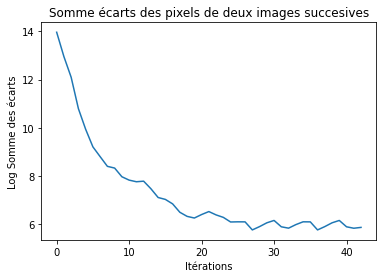

In [ ]:
plt.plot(np.log(liste_ecart[:43]))
plt.title("Somme écarts des pixels de deux images succesives")
plt.xlabel("Itérations")
plt.ylabel("Log Somme des écarts")

In [ ]:
# on crée une animation pour voir l'évolution : 
def animation_propagation(image_,itération,s,P):
    fig, ax = plt.subplots()
    im = ax.imshow(image_)
    def animate(i):
        image = maj_reseau(image_,s,P)
        im.set_data(image_)
        return im,
    anim = animation.FuncAnimation(fig, animate, frames=itération, interval=20, blit=True)
    plt.show()
    return anim

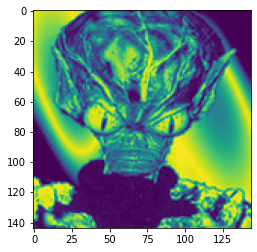

In [ ]:
# on génère une animation
anim = animation_propagation(image2,300,s,P)

In [ ]:
# on affiche l'animation
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('animation.mp4', writer=writer)
#HTML(anim.to_html5_video())